In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!python --version

Python 3.7.16


In [34]:
import pandas as pd
import numpy as np
import pingouin as pg

# 예제 데이터 생성
# X: 운동 시간, Y: 스트레스 지수, Z: 업무 시간
# 업무 시간(Z)이 많을수록 운동 시간(X)이 줄고, 스트레스 지수(Y)는 높아지는 관계
np.random.seed(42)
n = 100
data = pd.DataFrame({
    'X (운동 시간)': np.random.normal(5, 1, n),
    'Y (스트레스)': np.random.normal(50, 5, n),
    'Z (업무 시간)': np.random.normal(8, 2, n)
})

# Z의 영향을 X와 Y에 추가
data['X (운동 시간)'] = data['X (운동 시간)'] - 0.5 * data['Z (업무 시간)']
data['Y (스트레스)'] = data['Y (스트레스)'] + 2 * data['Z (업무 시간)']

# 단순 상관 분석 수행
print("--- 단순 상관 분석 (Z 통제 전) ---")
print(data.corr(method='pearson'))

--- 단순 상관 분석 (Z 통제 전) ---
           X (운동 시간)  Y (스트레스)  Z (업무 시간)
X (운동 시간)   1.000000 -0.539691  -0.714711
Y (스트레스)   -0.539691  1.000000   0.657874
Z (업무 시간)  -0.714711  0.657874   1.000000


In [35]:
# 편상관 분석 수행 (Z의 영향을 통제)
print("\n--- 편상관 분석 (Z 통제 후) ---")
# x: 'X (운동 시간)', y: 'Y (스트레스)', covar: 'Z (업무 시간)'
partial_corr_result = pg.partial_corr(data=data, x='X (운동 시간)', y='Y (스트레스)', covar='Z (업무 시간)', method='pearson')
print(partial_corr_result)


--- 편상관 분석 (Z 통제 후) ---
           n         r          CI95%        r2    adj_r2     p-val   BF10  \
pearson  100 -0.131943  [-0.32, 0.07]  0.017409 -0.002851  0.190679  0.291   

            power  
pearson  0.259133  


In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 예제 데이터 (위와 동일)
np.random.seed(42)
n = 100
data = pd.DataFrame({
    'X': np.random.normal(5, 1, n),
    'Y': np.random.normal(50, 5, n),
    'Z': np.random.normal(8, 2, n)
})
data['X'] = data['X'] - 0.5 * data['Z']
data['Y'] = data['Y'] + 2 * data['Z']

# 1. X를 Z로 회귀분석 후 잔차 구하기
X_model = sm.OLS(data['X'], sm.add_constant(data['Z'])).fit()
X_residuals = X_model.resid

# 2. Y를 Z로 회귀분석 후 잔차 구하기
Y_model = sm.OLS(data['Y'], sm.add_constant(data['Z'])).fit()
Y_residuals = Y_model.resid

# 3. 두 잔차 간의 상관관계 계산
partial_corr_manual = np.corrcoef(X_residuals, Y_residuals)[0, 1]

print(f"--- Statsmodels를 이용한 수동 계산 ---")
print(f"X와 Y의 편상관 계수 (Z 통제): {partial_corr_manual:.4f}") # -0.1319

--- Statsmodels를 이용한 수동 계산 ---
X와 Y의 편상관 계수 (Z 통제): -0.1319


In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 예제 데이터 생성
np.random.seed(42)
X1 = np.random.rand(100) * 10
X2 = np.random.rand(100) * 5
y = 3 + 2*X1 + 5*X2 + np.random.randn(100) * 2 # Y = 3 + 2*X1 + 5*X2 + error
data = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})

X = data[['X1', 'X2']]
y = data['y']

# 1. 상수항(절편) 추가
X_with_const = sm.add_constant(X)

# 2. OLS 모델 적합
# OLS(종속변수, 독립변수)
model = sm.OLS(y, X_with_const)
results = model.fit()

# 3. 모델 결과 요약 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1143.
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           3.70e-68
Time:                        00:35:45   Log-Likelihood:                -208.42
No. Observations:                 100   AIC:                             422.8
Df Residuals:                      97   BIC:                             430.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8212      0.508      5.549      0.0

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 예제 데이터 (위와 동일)
np.random.seed(42)
X1 = np.random.rand(100) * 10
X2 = np.random.rand(100) * 5
y = 3 + 2*X1 + 5*X2 + np.random.randn(100) * 2
data = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})

X = data[['X1', 'X2']]
y = data['y']

# 1. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. LinearRegression 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 3. 모델 계수 및 절편 확인
print(f"절편 (Intercept): {model.intercept_:.4f}") # 2.5865
print(f"회귀 계수 (Coefficients): {model.coef_}")  # [1.95000442 5.3148695 ]

# 4. 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)

# 5. 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n테스트 데이터 성능:")
print(f"MSE (Mean Squared Error): {mse:.4f}") # 2.6657
print(f"R-squared: {r2:.4f}")                 # 0.9749

절편 (Intercept): 2.5865
회귀 계수 (Coefficients): [1.95000442 5.3148695 ]

테스트 데이터 성능:
MSE (Mean Squared Error): 2.6657
R-squared: 0.9749


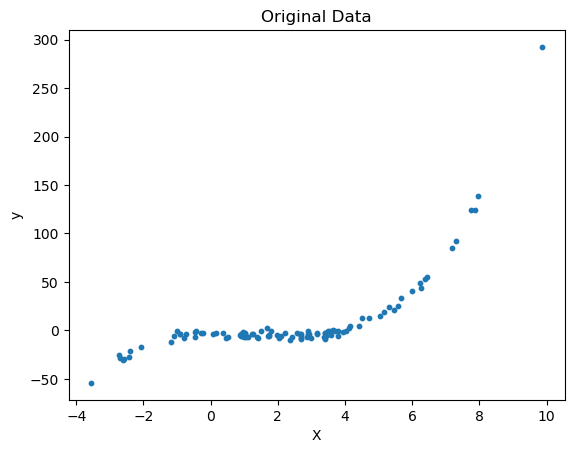

다항 회귀 (3차) MSE: 7.72
회귀 계수: [  2.11390416 -34.77258549  76.38175949]
절편: 9.911361945907691


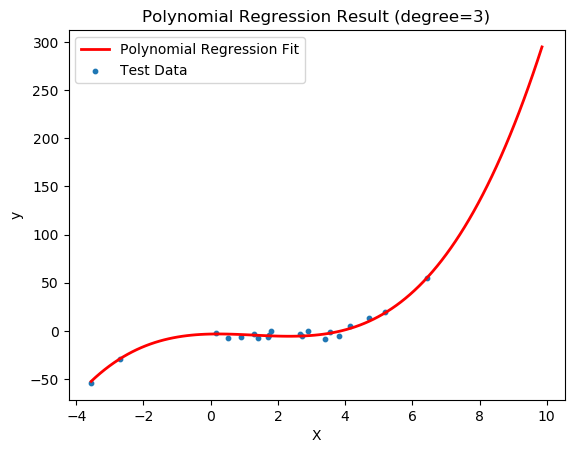

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. 데이터 생성 (비선형 관계)
np.random.seed(42)
X = 2 - 3 * np.random.normal(0, 1, 100)
y = X - 2 * (X ** 2) + 0.5 * (X ** 3) + np.random.normal(-3, 3, 100)
X = X[:, np.newaxis] # scikit-learn 입력을 위해 2D 배열로 변환

# 데이터 시각화
plt.scatter(X, y, s=10)
plt.title("Original Data")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 다항 특성 생성
# PolynomialFeatures 하이퍼파라미터
# degree: 다항식의 차수 (기본값=2). 높을수록 복잡한 곡선을 만들지만 과적합 위험이 커집니다.
# interaction_only: True이면 상호작용 항만 생성합니다 (e.g., x1*x2). 개별 변수의 거듭제곱 항(x1^2, x2^2)은 생성하지 않습니다. (기본값=False)
# include_bias: True이면 편향을 위한 특성(값이 1인 열)을 추가합니다. (기본값=True)
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

# 4. 스케일링 (선택 사항이지만 권장)
# 다항 특성 생성 후 스케일링을 적용합니다.
scaler = StandardScaler()
X_poly_train_scaled = scaler.fit_transform(X_poly_train)
X_poly_test_scaled = scaler.transform(X_poly_test)


# 5. 선형 회귀 모델 학습
lin_reg = LinearRegression()
lin_reg.fit(X_poly_train_scaled, y_train)

# 6. 예측 및 평가
y_pred = lin_reg.predict(X_poly_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"다항 회귀 (3차) MSE: {mse:.2f}") # 7.72
print(f"회귀 계수: {lin_reg.coef_}")     # [  2.11390416 -34.77258549  76.38175949]
print(f"절편: {lin_reg.intercept_}")     # 9.911361945907691

# 7. 결과 시각화
X_new = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
X_new_poly_scaled = scaler.transform(X_new_poly)
y_new = lin_reg.predict(X_new_poly_scaled)

plt.scatter(X_test, y_test, s=10, label="Test Data")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Polynomial Regression Fit")
plt.title("Polynomial Regression Result (degree=3)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

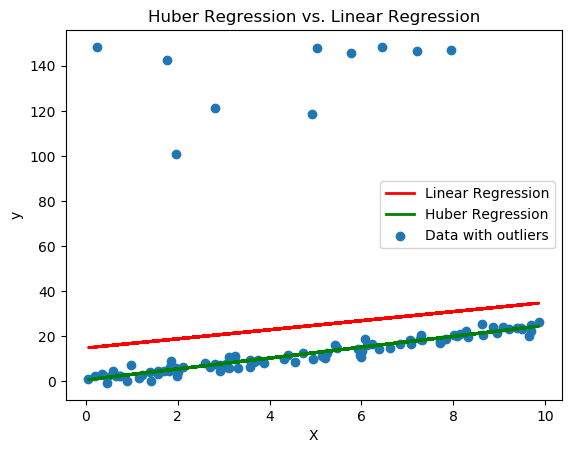

Huber 회귀 계수: [2.41020091], 절편: 0.6654725461601323
선형 회귀 계수: [2.01154445], 절편: 14.826638951529306


In [40]:
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 생성 (이상치 포함)
np.random.seed(42)
X = np.random.rand(100, 1) * 10
y = 2.5 * X.ravel() + np.random.randn(100) * 2

# 이상치 추가
X[90:] = np.random.rand(10, 1) * 10
y[90:] = np.random.rand(10) * 50 + 100

# 2. 모델 학습
# HuberRegressor 하이퍼파라미터
# epsilon: L1과 L2 손실을 전환하는 임계값. 이상치로 판단할 기준을 정합니다. (기본값=1.35)
#   - 데이터의 스케일에 따라 조정이 필요할 수 있습니다.
# alpha: 규제 강도. 모델의 복잡도를 제어합니다. (기본값=0.0001)
huber = HuberRegressor(epsilon=1.35)
huber.fit(X, y)

# 비교를 위한 일반 선형 회귀
lr = LinearRegression()
lr.fit(X, y)

# 3. 결과 시각화
plt.scatter(X, y, label='Data with outliers')
plt.plot(X, lr.predict(X), color='red', linewidth=2, label='Linear Regression')
plt.plot(X, huber.predict(X), color='green', linewidth=2, label='Huber Regression')
plt.title('Huber Regression vs. Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

print(f"Huber 회귀 계수: {huber.coef_}, 절편: {huber.intercept_}")
print(f"선형 회귀 계수: {lr.coef_}, 절편: {lr.intercept_}")

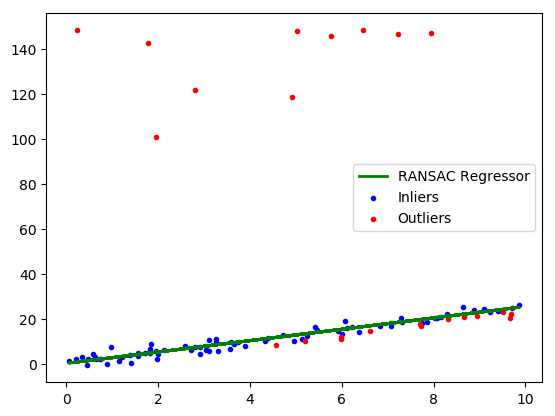

RANSAC 회귀 계수: [2.52161901], 절편: 0.23172065055441493


In [41]:
from sklearn.linear_model import RANSACRegressor

# RANSACRegressor 하이퍼파라미터
# base_estimator: 사용할 기본 모델 (e.g., LinearRegression). (기본값=LinearRegression())
# min_samples: 무작위로 선택할 최소 샘플의 개수. (기본값=None, X.shape[1] + 1)
# residual_threshold: 정상치로 판단할 최대 잔차(오차)의 크기. (기본값=MAD of y)
# max_trials: 최대 반복 횟수. (기본값=100)
ransac = RANSACRegressor(base_estimator=LinearRegression(), min_samples=50, residual_threshold=5.0, random_state=42)
ransac.fit(X, y)

# 결과 시각화
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.scatter(X[inlier_mask], y[inlier_mask], color='blue', marker='.', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='red', marker='.', label='Outliers')
plt.plot(X, ransac.predict(X), color='green', linewidth=2, label='RANSAC Regressor')
plt.legend()
plt.show()

print(f"RANSAC 회귀 계수: {ransac.estimator_.coef_}, 절편: {ransac.estimator_.intercept_}")
# RANSAC 회귀 계수: [2.52161901], 절편: 0.23172065055441493

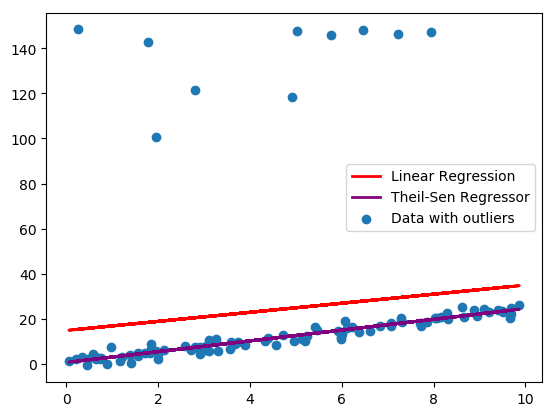

Theil-Sen 회귀 계수: [2.38914674], 절편: 0.6428816171681937


In [42]:
from sklearn.linear_model import TheilSenRegressor

# TheilSenRegressor 하이퍼파라미터
# n_subsamples: 기울기 계산 시 사용할 하위 샘플의 개수. 데이터가 클 때 계산 속도를 높이기 위해 사용. (기본값=n_samples)
# max_iter: 최대 반복 횟수. (기본값=300)
# random_state: 재현성을 위한 시드.
theil_sen = TheilSenRegressor(random_state=42)
theil_sen.fit(X, y)

# 결과 시각화
plt.scatter(X, y, label='Data with outliers')
plt.plot(X, lr.predict(X), color='red', linewidth=2, label='Linear Regression')
plt.plot(X, theil_sen.predict(X), color='purple', linewidth=2, label='Theil-Sen Regressor')
plt.legend()
plt.show()

print(f"Theil-Sen 회귀 계수: {theil_sen.coef_}, 절편: {theil_sen.intercept_}")
# Theil-Sen 회귀 계수: [2.38914674], 절편: 0.6428816171681937

In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 1. 데이터 생성 (이분산성)
np.random.seed(42)
n_samples = 200
X = np.random.uniform(0, 10, n_samples)
# X가 클수록 오차의 분산이 커지도록 설정
error = np.random.normal(0, X, n_samples) 
y = 10 + 2 * X + error

data = pd.DataFrame({'X': X, 'y': y})

# 2. OLS 모델과 분위수 회귀 모델(10%, 50%, 90%) 학습
# smf.quantreg('종속변수 ~ 독립변수', 데이터)
# q: 예측할 분위수 (0 < q < 1)
q_10 = smf.quantreg('y ~ X', data).fit(q=0.1)
q_50 = smf.quantreg('y ~ X', data).fit(q=0.5) # 중앙값 회귀
q_90 = smf.quantreg('y ~ X', data).fit(q=0.9)
ols = smf.ols('y ~ X', data).fit()

print("--- 10% 분위수 회귀 결과 ---")
print(q_10.summary())

--- 10% 분위수 회귀 결과 ---
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.2291
Model:                       QuantReg   Bandwidth:                       4.128
Method:                 Least Squares   Sparsity:                        14.01
Date:                Sun, 25 Jan 2026   No. Observations:                  200
Time:                        00:38:37   Df Residuals:                      198
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9227      0.565     17.557      0.000       8.808      11.037
X              0.9418      0.097      9.717      0.000       0.751       1.133


In [44]:
print("\n--- 50% 분위수(중앙값) 회귀 결과 ---")
print(q_50.summary())


--- 50% 분위수(중앙값) 회귀 결과 ---
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.4474
Model:                       QuantReg   Bandwidth:                       3.330
Method:                 Least Squares   Sparsity:                        10.06
Date:                Sun, 25 Jan 2026   No. Observations:                  200
Time:                        00:38:46   Df Residuals:                      198
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1705      0.685     14.855      0.000       8.820      11.521
X              2.0258      0.121     16.759      0.000       1.787       2.264


In [45]:
print("\n--- 90% 분위수 회귀 결과 ---")
print(q_90.summary())


--- 90% 분위수 회귀 결과 ---
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.5366
Model:                       QuantReg   Bandwidth:                       4.242
Method:                 Least Squares   Sparsity:                        13.99
Date:                Sun, 25 Jan 2026   No. Observations:                  200
Time:                        00:38:57   Df Residuals:                      198
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1672      0.611     16.628      0.000       8.961      11.373
X              3.0842      0.108     28.576      0.000       2.871       3.297


C:\Users\kangs\miniconda3\envs\ADP\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\kangs\miniconda3\envs\ADP\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


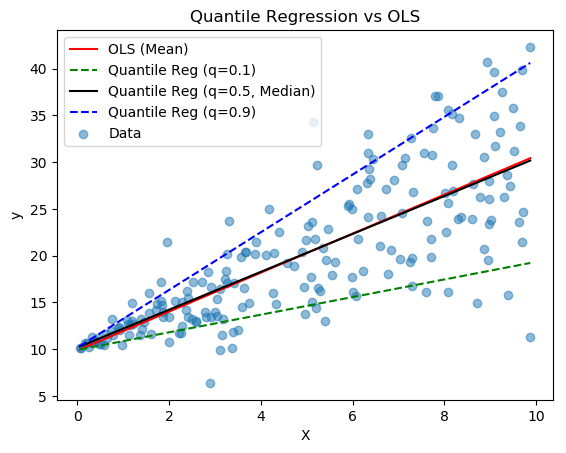

In [46]:
x_plot = np.linspace(data['X'].min(), data['X'].max(), 100)
plt.scatter(data['X'], data['y'], alpha=0.5, label='Data')
plt.plot(x_plot, ols.predict({'X': x_plot}), color='red', label='OLS (Mean)')
plt.plot(x_plot, q_10.predict({'X': x_plot}), color='green', linestyle='--', label='Quantile Reg (q=0.1)')
plt.plot(x_plot, q_50.predict({'X': x_plot}), color='black', label='Quantile Reg (q=0.5, Median)')
plt.plot(x_plot, q_90.predict({'X': x_plot}), color='blue', linestyle='--', label='Quantile Reg (q=0.9)')

plt.title('Quantile Regression vs OLS')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [47]:
from sklearn.linear_model import QuantileRegressor

# scikit-learn 입력을 위해 2D 배열로 변환
X_sk = X.reshape(-1, 1)

# QuantileRegressor 하이퍼파라미터
# quantile: 예측할 분위수 (0 < quantile < 1). (기본값=0.5)
# alpha: 규제 강도 (L1 규제). (기본값=1.0)
# solver: 최적화에 사용할 솔버. 데이터 크기에 따라 'highs', 'highs-ds', 'highs-ipm' 등을 선택. (기본값='highs')
q_reg_50 = QuantileRegressor(quantile=0.5, alpha=0)
q_reg_50.fit(X_sk, y)

print(f"Scikit-learn 50% 분위수 회귀 계수: {q_reg_50.coef_}, 절편: {q_reg_50.intercept_}")
# Scikit-learn 50% 분위수 회귀 계수: [2.02581967], 절편: 10.170481620593494

ImportError: cannot import name 'QuantileRegressor' from 'sklearn.linear_model' (C:\Users\kangs\miniconda3\envs\ADP\lib\site-packages\sklearn\linear_model\__init__.py)

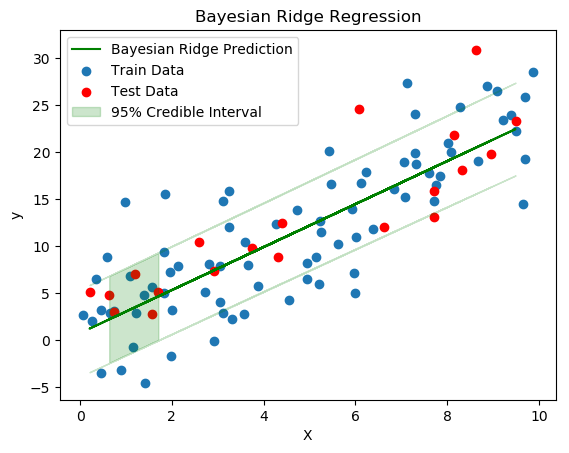

추정된 회귀 계수 (평균): [2.28556861]
추정된 절편 (평균): 0.7789537607408423
추정된 alpha (오차의 정밀도): 0.0466
추정된 lambda (가중치의 정밀도): 0.1903


In [48]:
import numpy as np
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 생성
np.random.seed(42)
X = np.random.rand(100, 1) * 10
y = 2.5 * X.ravel() + np.random.randn(100) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 모델 학습
# BayesianRidge 하이퍼파라미터
# n_iter: 최대 반복 횟수. (기본값=300)
# tol: 수렴 조건. (기본값=1e-3)
# alpha_1, alpha_2: alpha(정밀도) 사전분포(감마분포)의 하이퍼파라미터. (기본값=1e-6)
# lambda_1, lambda_2: lambda(정밀도) 사전분포(감마분포)의 하이퍼파라미터. (기본값=1e-6)
#   - 이 값들은 보통 기본값을 사용하며, 모델이 데이터로부터 alpha와 lambda를 추정하게 됩니다.
br = BayesianRidge()
br.fit(X_train, y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

# 3. 예측 및 불확실성 확인
# return_std=True로 설정하면 예측값의 표준편차를 함께 반환합니다.
y_pred_br, y_std_br = br.predict(X_test, return_std=True)
y_pred_lr = lr.predict(X_test)

# 4. 결과 시각화
plt.scatter(X_train, y_train, label='Train Data')
plt.scatter(X_test, y_test, color='red', label='Test Data')

# 베이지안 회귀 예측 및 신용 구간
plt.plot(X_test, y_pred_br, color='green', label='Bayesian Ridge Prediction')
plt.fill_between(X_test.ravel(), y_pred_br - y_std_br, y_pred_br + y_std_br, color='green', alpha=0.2, label='95% Credible Interval')

plt.title('Bayesian Ridge Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# 5. 추정된 파라미터 확인
print(f"추정된 회귀 계수 (평균): {br.coef_}")               # [2.28556861]
print(f"추정된 절편 (평균): {br.intercept_}")               # 0.7789537607408423
print(f"추정된 alpha (오차의 정밀도): {br.alpha_:.4f}")     # 0.0466
print(f"추정된 lambda (가중치의 정밀도): {br.lambda_:.4f}") # 0.1903

In [49]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 데이터 생성
np.random.seed(42)
X = pd.DataFrame({
    'hour': np.arange(8, 22).repeat(10), # 오전 8시 ~ 오후 9시
    'is_weekend': np.random.randint(0, 2, 140)
})
# 시간에 따라 방문자 수가 변하고, 주말에 더 많다고 가정
lambda_val = np.exp(0.5 + 0.1 * (X['hour'] - 8) + 0.5 * X['is_weekend'])
y = np.random.poisson(lambda_val)

X_const = sm.add_constant(X)

# 모델 학습
# family=sm.families.Poisson(): 푸아송 분포와 로그 연결 함수(기본값)를 사용
poisson_model = sm.GLM(y, X_const, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print("--- 푸아송 회귀 결과 ---")
print(poisson_results.summary())

--- 푸아송 회귀 결과 ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  140
Model:                            GLM   Df Residuals:                      137
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -306.35
Date:                Sun, 25 Jan 2026   Deviance:                       178.94
Time:                        00:42:54   Pearson chi2:                     166.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6142
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2723      0.183  

In [50]:
# 음이항 회귀 모델 학습
# family=sm.families.NegativeBinomial(): 음이항 분포와 로그 연결 함수 사용
# 단, 해당 방식은 alpha 값 출력이 이루어지지 않아, sm.NegativeBinomial 함수로 진행
neg_binom2 = sm.NegativeBinomial(y, X_const)
neg_binom2_results = neg_binom2.fit()

print(neg_binom2_results.summary())

Optimization terminated successfully.
         Current function value: 2.184673
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                  140
Model:               NegativeBinomial   Df Residuals:                      137
Method:                           MLE   Df Model:                            2
Date:                Sun, 25 Jan 2026   Pseudo R-squ.:                  0.1195
Time:                        00:43:05   Log-Likelihood:                -305.85
converged:                       True   LL-Null:                       -347.36
Covariance Type:            nonrobust   LLR p-value:                 9.461e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2670      0.192     -

In [51]:
# 1. 데이터 생성
np.random.seed(123)
X_gamma = pd.DataFrame({
    'driver_age': np.random.randint(18, 70, 100),
    'car_value': np.random.uniform(500, 50000, 100)
})
# 나이가 적고 차 가격이 비쌀수록 청구액이 높다고 가정
mu = np.exp(10 - 0.02 * X_gamma['driver_age'] + 0.00001 * X_gamma['car_value'])
# 감마 분포는 shape(alpha)와 scale(beta) 파라미터를 가짐. 여기서는 shape=2로 고정.
y_gamma = np.random.gamma(shape=2., scale=mu/2.)

X_gamma_const = sm.add_constant(X_gamma)

# 2. 모델 학습
# family=sm.families.Gamma(link=sm.families.links.log()): 감마 분포와 로그 연결 함수 사용
# 감마 회귀는 역수(inverse) 연결 함수가 기본값이지만, 로그 연결이 해석에 용이할 때가 많음.
gamma_model = sm.GLM(y_gamma, X_gamma_const, family=sm.families.Gamma(link=sm.families.links.log()))
gamma_results = gamma_model.fit()

print("\n--- 감마 회귀 결과 ---")
print(gamma_results.summary())


--- 감마 회귀 결과 ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                         0.53893
Method:                          IRLS   Log-Likelihood:                -1021.3
Date:                Sun, 25 Jan 2026   Deviance:                       65.872
Time:                        00:43:22   Pearson chi2:                     52.3
No. Iterations:                    14   Pseudo R-squ. (CS):             0.2188
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6546      0.266  